<a href="https://colab.research.google.com/github/JSJeong-me/AI-Innovation-2024/blob/main/NLP/4-4-Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## K-means Clustering in Python using OpenAI

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Get_embeddings_from_dataset Notebook](Get_embeddings_from_dataset.ipynb).

In [1]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import os

userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
api_key = os.getenv("OPENAI_API_KEY")

In [3]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1jfmC2bkgmsjC56xlOeNyrIOytxPMJP6R' -O fine_food_reviews_with_embeddings_1k.csv

--2024-10-03 14:06:04--  https://drive.google.com/uc?export=download&id=1jfmC2bkgmsjC56xlOeNyrIOytxPMJP6R
Resolving drive.google.com (drive.google.com)... 142.250.101.102, 142.250.101.139, 142.250.101.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jfmC2bkgmsjC56xlOeNyrIOytxPMJP6R&export=download [following]
--2024-10-03 14:06:05--  https://drive.usercontent.google.com/download?id=1jfmC2bkgmsjC56xlOeNyrIOytxPMJP6R&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35255462 (34M) [application/octet-stream]
Saving to: ‘fine_food_reviews_with_embeddings_1k.csv’

fine_food_reviews_w 100%[===========

In [4]:
# imports
import numpy as np
import pandas as pd
from ast import literal_eval

# load data
datafile_path = "./fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape


(1000, 1536)

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [5]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()


,Score
Cluster,
3,4.119601
0,4.185930
2,4.206767
1,4.380342


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

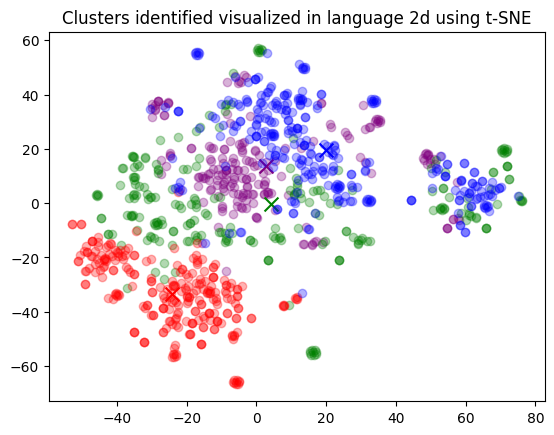

In [6]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use gpt-4 to name the clusters, based on a random sample of 5 reviews from that cluster.

In [7]:
from openai import OpenAI
import os

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )

    messages = [
        {"role": "user", "content": f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:'}
    ]

    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0)
    print(response.choices[0].message.content.replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme: All the reviews are about food products.
4, Fine for a microwave dinner:   The Barilla Mezze Penne with spicy marinara sauce is easy to prepare a
3, Hot!:   It tastes hotter than other gari products I've tried, but it's not a p
5, Red Chili Fettuccinne:   This product is great - looks, cooking time and taste.  Have been usin
3, Product expiration & bulk ordering:   The product itself is pretty straight forward.  It's got pureed organi
4, Perfect for a quick lunch!:   I was impressed with this meal, I couldn't imagine the quality Barilla
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: Product Reviews
2, Paw Flapper Fun, But Too Easy:   I got my dog the Paw Flapper because he's a Basset Hound mix and loves
3, Hot Apple Cider:   This was very good for the most part. I like to drink it in the chilly
5, Bing:   I love that I can still get this product in California even though it 
4, Almost Perfect!:   I 

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.